Safecast : Band-limited interpolation of radiation measurements in Fukushima
============================================================================

Summary
-------

In this notebook, we'll use radiation data from around the Fukushima Dai-ichi power plant in Japan to demonstrate some basic band-limited interpolation techniques.

__Disclaimer__: This notebook is fairly heavy to run in terms of memory usage. A machine with at least 8GB of RAM is recommended.

History
-------

When a tsunami hit the coast of Japan on March 11 2011, in addition to the terrible devastation brought in by the tidal wave, another disaster unfolded, the infamous nuclear disaster of the Fukushima Dai-ichi nuclear power station. Under the assault of waves over 14 meters, three nuclear reactors underwent meltdown, explosions, and are to this day not yet under control.

![Explosion](http://i.telegraph.co.uk/multimedia/archive/01847/smoke_1847738c.jpg)

A consequence of the accident was the release of important quantities of radioactive material into the environment. In spite of the potential danger faced by the population, virtually no information concerning the levels of radioactive contamination was released by either the power utility company or the governement of Japan. It was quickly clear that the reason was not only the reluctance of official bodies to release the information, but that for the most part the information did not exist in the first place.

Facing this situation, [Safecast](http://blog.safecast.org/), an international group of concerned citizens, quickly formed after the disaster. To remediate to the lack of the data, the group decided to build sensor themselves and lend them to volunteers that could in turn take the measurements and share them back with the community through a common database.

<img src='http://i.imgur.com/wfa34yD.jpg' width=500>

To streamline the collection of data, a new type of mobile sensor was developped with the help of [Tokyo Hackerspace](http://tokyohackerspace.org/), the bGeigie. The bGeigie includes an Arduino for the brains, a GPS, an SD card, and a Geiger tube (with high voltage). The dose rate is measurement using the Geigier counter, tagged with time and GPS coordinates and recorded to the SD card. The device straps to the outside of a car (or bike, or backpack, etc) and automatically takes a measurement every five seconds. This allows for extremely efficient collection of measurements.

<img src='http://i.imgur.com/EeRcK0K.jpg' width=400>  <img src='http://i.imgur.com/FLNtxDZ.jpg' width=200>

This strategy allowed to gather data at a very high rate and today most of Japan, as well as some other areas around the world have been covered. The whole dataset can be [downloaded](https://api.safecast.org/system/measurements.csv) or visualized on [maps](http://safecast.org/tilemap). More than 19 million individual measurements have been collected so far.

<a href='http://safecast.org/tilemap'>
<img src='https://i.imgur.com/uTvHT0h.png' width=800>
</a>

Band-limited interpolation
--------------------------

Interpolation deals with the reconstruction of a continuous field from a set of discrete measurements. Band-limited refers to the case where we make the extra assumption that the field we wish to reconstruct does not have any high-frequency. 

As one might expect, this requirement can be expressed in the language of Fourier analysis. But first, let's make the extra two following assumptions.

1. We are only interested in a finite interval $[x_1,x_2]$.
2. The function is periodic with period $T = x_2 - x_1$.

Then, the Fourier transform of the function will be zero everywhere, except at integer locations (this can be understood by constructing the function as the convolution of a pulse train with the windowed interval, and then applying the convolution theorem). Thus, we only need to compute the Fourier transform at integer frequencies. (This is in fact a [Fourier series](https://en.wikipedia.org/wiki/Fourier_series) and is the original work by [Joseph Fourier](https://en.wikipedia.org/wiki/Jean-Baptiste_Joseph_Fourier), but we will not go into details here.)

Adding the band-limitdness assumption to this, we can write the Fourier expansion of the function as a finite sum
$$
f(x) = \sum_{k=-M}^M c_k e^{j2\pi \frac{k x}{T}}, \quad t\in \mathbb{R}.
$$

In this notebook, we will first study interpolation of 1D signals to understand the technique. Then we will apply the same technique to the 2D radiation field using the Safecast dataset.

Band-limited interpolation of 1D signals
----------------------------------------

Let's assume we have a number of measurements from a 1D field.

$$
\{(x_i,z_i)\}_{i=0}^{N-1}
$$

such that $z_i = f(x_i)$ and $f(x)$ is a bandlimited function as described above. This means that the following equations are satisfied.

$$
z_i = \sum_{k=-M}^M c_k\, e^{j2\pi\frac{k x_i}{T}},\ i=0,\ldots,N-1.
$$

This equation can be rewritten in matrix form as

$$
F\mathbf{c} = \mathbf{z},
$$

where $\{F\}_{ik} = e^{j2\pi\frac{x_i k}{T}}$, $\mathbf{c}=[c_{-M},\ldots,c_{M}]^T$ is a vector containing the Fourier coefficients, and $\mathbf{z}=[z_0,\ldots,z_{N-1}]^T$ are the measurements.

Note that we keep $i$ from $0$ to $N-1$, and $k$ from $-M$ to $M$, as in the initial sum. In the matrix notation, this simply means that the upper left entry of the matrix is $F_{0,-M}$.

Assuming that $N \geq 2M+1$, this system can be solved in the least-square sense to give an approximation of the Fourier coefficients

$$
\hat{\mathbf{c}} = (F^TF)^{-1}F^Tz.
$$

Given the estimated Fourier coefficients, it is now possible to estimate the field on different set of points, e.g. a regular grid. Let $\tilde{x}_i = i\frac{T}{L}$, the regularly spaced grid. Then the function at these points is

$$
\tilde{\mathbf{z}} = \tilde{F}\hat{c},
$$

where $\{\tilde{F}\}_{ik} = e^{j2\pi\frac{\tilde{x}_i k}{T}}$.

Let's now put this in practice.

In [1]:
# import pylab and make figure size something nice for display
%pylab inline
figsize(8,6)

Populating the interactive namespace from numpy and matplotlib


We start by defining a function that will take care of the interpolation as described above. It takes as arguments the measurements, the interval, the maximum order of the Fourier coefficients, and optionally a grid step size (and a conditional argument to use a window function, but more about this later).

In [2]:
def BL_interp_1D(x, z, T, order, grid_step=0.01, win=True):
    """
    Band-limited interpolation of 1D functions
    """
    
    # Create Fourier order vector
    k = expand_dims(arange(-order, order+1), 0)
    
    # construct the Fourier matrix
    F = exp(2j*pi*x*k/(T[1]-T[0]))
    
    # Least-square projection (alternatively numpy.linalg.lstsq can be used)
    C = dot(dot(linalg.inv(dot(F.T,F)), F.T), z)
    
    # create new evenly spaced grid
    xg = expand_dims(arange(T[0], T[1], grid_step), 1)
    
    # window the Fourier coefficients if requested
    if (win):
        C *= expand_dims(hanning(2*order+1), 1)
    
    zg = dot(exp(2j*pi*xg*k/(T[1]-T[0])), C)
        
    return zg, xg, C, k

Now, we will take randomly spaced samples from a the band-limited function $f_{BL}(x) = 2\sin(2\pi x) - 4\cos(2\pi 4 x)$, and try to interpolate the function on a new grid.

<ipython-input-4-a19336317e80>:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  stem(k1.T, abs(C1))


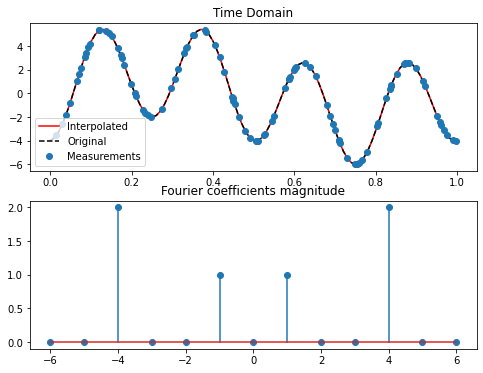

In [4]:
# define the f_BL as a function for convenience
def f_BL(x):
    return 2*np.sin(2*pi*1*x) - 4*np.cos(2*pi*4*x)

# Take a random set of measurements on [0,2\pi]
T = [0, 1]
order = 6

x = (T[1]-T[0])*random.random((100,1))+T[0]
z = f_BL(x)

zp1, xp1, C1, k1 = BL_interp_1D(x, z, T, order, win=False)

subplot(2,1,1)
plot(xp1, real(zp1), 'r-', xp1, f_BL(xp1), 'k--', x, z, 'o')
title('Time Domain')
legend(('Interpolated', 'Original','Measurements'))

subplot(2,1,2)
stem(k1.T, abs(C1))
title('Fourier coefficients magnitude')
show()

We notice that we recover the exact original field. This happens because the field we chose perfectly match our band-limited hypothesis. One could ask, what if the field is not band-limited ? Can we do anything ?

Let's try with a non band-limited function. We take the function $f_2(x)=(|x|-0.5)^2$ for $x\in[-0.5,0.5]$ and periodized with period $T=1$. This function is continuous, but not differentiable. It has a sharp angle at $x=0$ and is therefore not band-limited.

<ipython-input-6-23c41639cac5>:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  stem(k1.T, abs(C1), 'k')


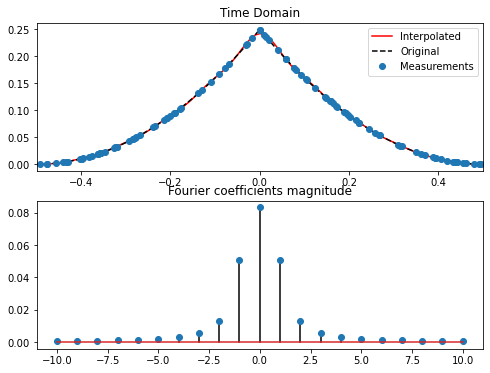

In [6]:
def f2(x):
    return (abs(x)-0.5)**2

T = [-0.5, 0.5]
order = 10

x = (T[1]-T[0])*random.random((100,1))+T[0]
z = f2(x)

# compute BL interpolation
zp1, xp1, C1, k1 = BL_interp_1D(x, z, T, order, win=False)

# plot the result
subplot(2,1,1)
plot(xp1, real(zp1), 'r-', xp1, f2(xp1), 'k--', x, z, 'o')
xlim([-0.5,0.5])
title('Time Domain')
legend(('Interpolated', 'Original','Measurements'))

subplot(2,1,2)
stem(k1.T, abs(C1), 'k')
title('Fourier coefficients magnitude')

show()

The function $f_2(x)$, although continuous, is not differentiable around zero. This means that it is not band-limited. We can understand it in the following way. To approximate the sharp edge at zero with the smooth sine and cosine of the Fourier expansion, an infinite number of coefficients is necessary. However, we see that except around zero, where the sharp angle is smoothed out, our approximation is still excellent.

What if we deal with a discontinuous function ? To test this we will use $f_3(x) = x^2$ for $x\in[0,1)$ and periodized with $T=1$.

<ipython-input-8-6747b56ac5f5>:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  stem(k1.T, abs(C1), 'k')


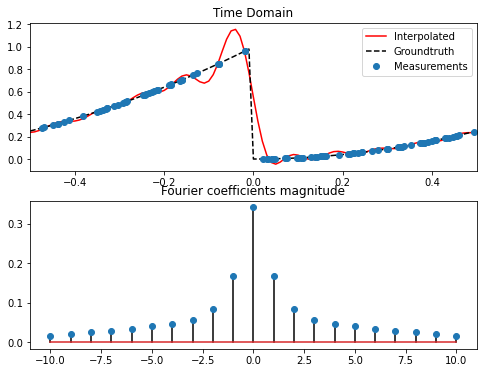

In [8]:
# we use fractional part function modf to compactly write f_3
def f3(x):
    return (x-floor(x))**2

T = [-0.5, 0.5]
order = 10

x = (T[1]-T[0])*random.random((100,1))+T[0]
z = f3(x)

# compute BL interpolation
zp1, xp1, C1, k1 = BL_interp_1D(x, z, T, order, win=False)

# plot the result
subplot(2,1,1)
plot(xp1, real(zp1), 'r-', xp1, f3(xp1), 'k--', x, z, 'o')
xlim([-0.5,0.5])
title('Time Domain')
legend(('Interpolated', 'Groundtruth','Measurements'))

subplot(2,1,2)
stem(k1.T, abs(C1), 'k')
title('Fourier coefficients magnitude')

show()

We see that in this case, the discontinuity requires much more high frequency coefficients to be well approximated (in fact, one can show that the Fourier coefficients only decrease as $\sim\frac{1}{k}$). One way to understand what is happening is to see the band-limited approximation as applying a rectangular window in the frequency domain

$$
\hat{c}_k = w_k c_k
$$

with $w_k = 1$ if $|k| \leq M$, and zero otherwise. By one of the fundamental properties of the Fourier transform, we know that the resulting time domain signal will be convolved with the Fourier expansion of the rectangular window, i.e. the sinc function. Which explains the wiggles we see.

A solution to this problem is to apply a different window function that is better behaved in the time domain. For example, the [Hann window](https://en.wikipedia.org/wiki/Hann_function). Essentially, we are trading off resolution for smoothness. For a detailed discussion of window functions, one can refer to the [wikipedia entry](https://en.wikipedia.org/wiki/Window_function) on the subject.

Let's see now what we obtain using the window function.

<ipython-input-9-db83bc1813ef>:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = stem(k1.T, abs(C1), 'k')
<ipython-input-9-db83bc1813ef>:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = stem(k2.T, abs(C2), 'k')


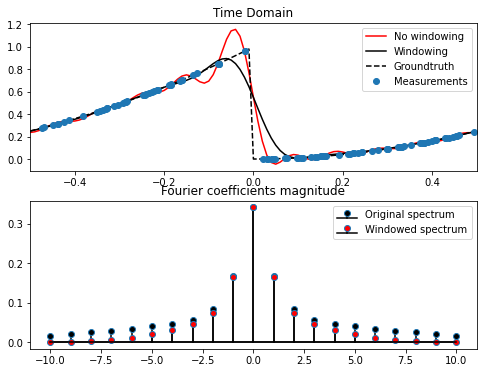

In [9]:
# compute BL interpolation
zp2, xp2, C2, k2 = BL_interp_1D(x, z, T, order, win=True)

# plot the result
subplot(2,1,1)
plot(xp1, real(zp1), 'r-', xp2, real(zp2), 'k-', xp1, f3(xp1), 'k--', x, z, 'o')
xlim([-0.5,0.5])
title('Time Domain')
legend(('No windowing', 'Windowing','Groundtruth','Measurements'))

subplot(2,1,2)
markerline, stemlines, baseline = stem(k1.T, abs(C1), 'k')
setp(markerline, 'markerfacecolor', 'k')
setp(baseline, 'color','k')
markerline, stemlines, baseline = stem(k2.T, abs(C2), 'k')
setp(markerline, 'markerfacecolor', 'r')
setp(baseline, 'color','k')
legend(('Original spectrum', 'Windowed spectrum'))
title('Fourier coefficients magnitude')
show()

We observe that we lost some sharpness at the discontinuity by applying the window. However, we gained a lot of smoothness and far better approximation in the rest of the signal.

Band-limited interpolation of 2D signals
----------------------------------------

The principles we will apply here are identical to 1D signals. The only difficulty is to write our 2D equation in matrix form. However, as we will see, python offers facilities for this.

Let's assume we have now measurements from a 2D field,

$$
\{(x_i,y_i,z_i)\}_{i=0}^{N-1}
$$

where $z_i = f(x_i,y_i)$. Assuming $f(x,y)$ is a band-limited function, we can write each measaurement as a Fourier expansion

$$
z_i = f(x,y) = \sum_{k=-M}^M\sum_{l=-M}^M c_{kl}\, e^{j2\pi\left(\frac{x_i k}{T_x}+\frac{y_i l}{T_y}\right)},
$$

where again we assumed $f(x,y)$ is periodic with periods $T_x$ and $T_y$ in the $x$ and $y$ directions, respectively. We can again rewrite this in matrix form $F\mathbf{c} = \mathbf{z}$. This is possible by linearizing 2D indices $k,l$ in the following way for example $\mathbf{c}_{k+(2M+1)l} = c_{kl}$ and $\{F\}_{i,k+(2M+1)l} = e^{j2\pi\left(\frac{x_i k}{T_x}+\frac{y_i l}{T_y}\right)}$, and $\mathbf{z}$ as before (we assumed here that we shift $k$ and $l$ to be positive). In practice, we'll use python built-in routines to do this task (so exact order may vary), in particular check the [`meshgrid`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) and [`reshape`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) routines. Thus, if we are careful about the reordering of the coefficients, we can re-use the exact same technique as in the 1D case!

Interpolate Safecast data around Fukushima Dai-ichi power plant
---------------------------------------------------------------

We start by importing the data. Be careful, if the data is not available locally, a 2 GB file has to be downloaded and processed. This can take some time.

For convenience, we restrict the Safecast dataset to measurements made around the stricken nuclear power plant. We also remove very large measurements as they tend to be very spotty and throw off the interpolation (they have very large bandwidth). This kind of preprocessing is typical of real-world datasets and needs to be adjusted on a case by case basis.

In [11]:
import pandas as pd
import datetime as dt
import os

# Limit data to use in space and time
lat_min, lon_min, lat_max, lon_max = 37.037571, 139.540087, 37.856355, 141.050707  # Fukushima area only
dr = ['2011-03-11', '2012-03-11']  # Limit time to first year after accident
Value_max = 2500   # Discard very large samples as they tend to throw off interpolation

# data filename
filename = 'Safecast_data.txt'

# If the data file do not exist, we just grab all the data from Safecast's website
if (not os.path.isfile(filename)):
    
    local_full_dataset = 'measurements.csv'
    
    # if the file is not locally present, download from Safecast website
    if (not os.path.isfile(local_full_dataset)):
        df = pd.read_csv('https://api.safecast.org/system/measurements.csv', parse_dates=True, index_col=0)
    else:
        df = pd.read_csv(local_full_dataset, parse_dates=True, index_col=0)
    
    # sort the index to be ordered chronologically
    df.sort_index(inplace=True)
    
    # Select the measurements in that space-time interval
    map_space = logical_and(logical_and(df.Latitude > lat_min, df.Latitude < lat_max), logical_and(df.Longitude > lon_min, df.Longitude < lon_max))
    map_mag = logical_and(df.Value > 0, df.Value < Value_max)
    df_fuku = df[['Longitude','Latitude','Value']][logical_and(map_space, map_mag)][dr[0]:dr[1]]
    
    # save locally for further use
    df_fuku.to_csv(filename)

else:
    df_fuku = pd.read_csv(filename, error_bad_lines=False)
    
    
print('Number of measurements: ', len(df_fuku))

Number of measurements:  941573


__Note__: The computational burden of the notebook can be decreased by subsampling the vector `df_fuku` here (only keeping one out of every $x$ entries for example).

Now, let's take a look at the data we have at hand. Since they were taken with a car, we expect the measurements to line up into trajectories following the road network.

<class 'pandas.core.frame.DataFrame'>


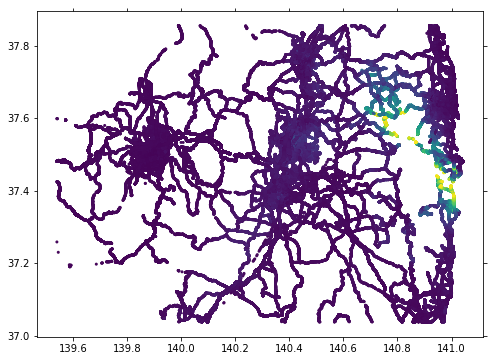

In [12]:
ax = subplot(111)
print(type(df_fuku))
plt.scatter(df_fuku.Longitude, df_fuku.Latitude, c=df_fuku.Value, marker='.', edgecolor='none')

plt.tick_params(\
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off', top='off', right='off', left='off',         # ticks along the top edge are off
    labelbottom='off',labelleft='off') # labels along the bottom and left edges are off

ax.set_aspect('equal')
axis('tight')

show()

### Interpolation

Let's go into the interpolation of the 2D radiation field. We mentionned earlier that one of the hidden assumption of our model is that the signal is periodic. It is thus possible to see wrap-around artifacts appear in our interpolation. To reduce this, we add an area empty of measurements. Effectively, we fix our interval to start a pre-defined distance from the closest measurement in all direction.

It turns out also that we need to use another dirty trick here in order to get a good interpolation. Real-world measurements are unfortunately subject to noise. Especially low-level radiation data inherently has low signal-to-noise ratio. In addition, our data contains many redundant, or close to redundant points, leading to a poorly condition $F$ matrix. To better conditionned the matrix, a singular value decomposition is used and the singular values lower than some threshold are discarded. This allows to decrease the [condition number](https://en.wikipedia.org/wiki/Condition_number) of the $F$ matrix and obtain a stable solution to the system. This functionality is luckily implemented in the [`lstsq`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) function from numpy.

Note that the following piece of code is where the heavy number crunching is done and you'll need a fair amount of RAM to run it.

In [13]:
# Choose an order and a padding size for the interpolation
order = 10
padding = 0.2 # unit is in degrees for lat/lon

# Recenter the coordinates to start at origin
x = expand_dims(df_fuku.Longitude - lon_min + padding, 1)
y = expand_dims(df_fuku.Latitude - lat_min + padding, 1)
z = expand_dims(df_fuku.Value, 1)

# The size of the interval to interpolate
Tx = x.max() + padding
Ty = y.max() + padding

# construct our Fourier order vectors
k = arange(-order, order+1)
l = arange(-order, order+1)
K,L = meshgrid(k,l)

# vectorize
linK = reshape(K, (1, -1))
linL = reshape(L, (1, -1))

# make the matrix
# Note, we rely here on broadcasting by numpy to get the matrix for all pairs of entries from x/linK and y/linL
F = exp(2j*pi*(x*linK/Tx + y*linL/Ty))/sqrt(Tx*Ty)

# Least-square projection
C = linalg.lstsq(F, z, 1e-2)[0]

Let's now take a first look at the spectrum we obtained. We notice the plume like behavior. We also see that the spectrum does not decay gracefully to zero within the order that we chose. To mitigate this, we could either choose a higher order $M$ for the band-limited spectrum, or window the spectrum before reconstruction to smooth things. We will choose the latter here as the addition of more coefficients increases rapidly the amount of memory necessary to solve the least-square problem.

Of course, this also means that we are actually dealing with a field actually not band-limited and our reconstruction will thus be inexact. We hope however that we will get a good idea of the large-scale behavior of the field.

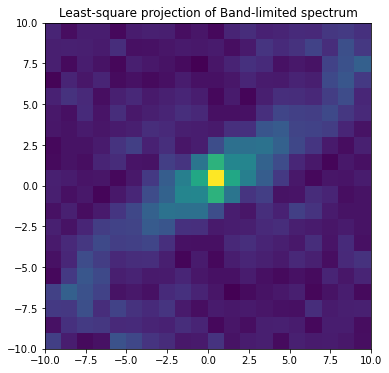

In [14]:
ax = subplot(1,1,1)
ax.pcolormesh(K, L, (abs(reshape(C, (2*order+1, 2*order+1)))))
ax.set_aspect('equal')
axis([-order, order, -order, order])
title('Least-square projection of Band-limited spectrum')
show()

We now compute the value of our interpolation on a fine regularly spaced grid over the area. We use the same type of vectorization to go from the 2D representation to our matrix notation described above.

In [15]:
# Pick the spacing of the grid
step = 0.005

# regularly spaced grid
xg = arange(0, Tx, step)
yg = arange(0, Ty, step)

# vectorize
Xg, Yg = meshgrid(xg, yg)
linXg = reshape(Xg, (1, -1)).T
linYg = reshape(Yg, (1, -1)).T

# 2D Hann window
W = expand_dims(hanning(2*order+1), 1)
W = W*W.T
Wlin = reshape(W, (1, -1)).T

# Reconstruct after applying the Hann window
Zprime = dot(exp(2j*pi*(linXg*linK/Tx + linYg*linL/Ty))/sqrt(Tx*Ty), Wlin*C)

# Reshape the result into the original 2D representation
ZI = real(reshape(Zprime, (len(yg), len(xg))))

We can now plot the interpolated field. To do so, we also drop the padding area we added previously since it doesn't correspond to anything real. Here we plot in the latitude/longitude domain without any special projection, which means the field is somewhat deformed.

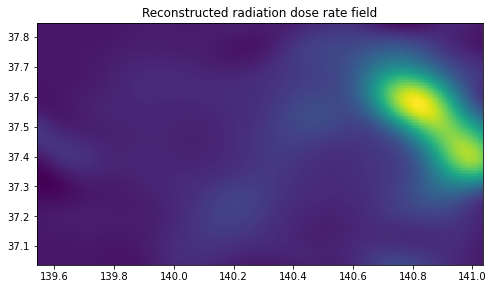

In [22]:
xmin, xmax = int(padding/step), int((Tx-padding)/step)
ymin, ymax = int(padding/step), int((Ty-padding)/step)

Lon = Xg[ymin:ymax,xmin:xmax] + lon_min - padding
Lat = Yg[ymin:ymax,xmin:xmax] + lat_min - padding
Field = ZI[ymin:ymax,xmin:xmax]

ax = subplot(1,1,1)
ax.pcolormesh(Lon, Lat, Field)
ax.set_aspect('equal')
axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
title('Reconstructed radiation dose rate field')
show()

To give a nicer touch to this graph, we will use the `basemap` package from matplotlib to project the reconstructed field on a map. We will also indicate the position of the nuclear power plant, as well as the coast line of Japan.

The `basemap` package is absent from some python distribution (notably Anaconda) and need to be installed by hand. With Anaconda, it is enough to open a terminal and type in the following.

        conda install basemap


In [23]:
from mpl_toolkits.basemap import Basemap

# create figure, axes instances.
fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
#
m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='lcc',\
            lat_1=lat_min-padding,lat_2=lat_max+padding,lat_0=(lat_max+lat_min)/2.,lon_0=(lon_max+lon_min)/2.)

# draw line around map projection limb.
m.drawmapboundary(fill_color='0.3')
m.drawcoastlines(linewidth=2)
m.drawstates()
m.drawparallels(arange(37.1,38,0.2),labels=[1,1,0,0], fontsize=14)
m.drawmeridians(arange(139.5,141.5,0.5),labels=[0,0,1,0], fontsize=14)

# plot sst, then ice with pcolor
#im1 = m.pcolormesh(Xg+lon_min-padding, Yg+lat_min-padding,ZI,shading='flat',cmap=plt.cm.jet,latlon=True)

nx = int((m.xmax-m.xmin)/50.)+1; ny = int((m.ymax-m.ymin)/50.)+1
ZIdat = m.transform_scalar(Field, Lon[0],Lat.T[0], nx, ny)
im1 = m.imshow(ZIdat)

# Add Dai-ichi power station
daiichi = (37.421463, 141.032556)
m.scatter(daiichi[1], daiichi[0], latlon=True, marker='*', s=400, color='k')

# add colorbar
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('Radiation dose rate', fontsize=20)
cb.set_ticks([ZIdat.min(), ZIdat.max()])
cb.set_ticklabels(('low','high'))
cb.ax.tick_params(labelsize=20) 

show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

To conclude, we can compare our reconstruction to a different interpolation. The interpolation we compare to is done using non-lniear techniques and does not suppose any band-limitedness of the data. It is thus evidently superior. However, we can observe that the band-limited interpolation still gives an excellent first-order approximation.

<img src='http://i.imgur.com/08Aa4KA.png' width=800>